## Building website-specific functionality
The real power of selene comes from using it as a starting framework from which to develop website-specific functionality. 

Here, we illustrate building website specific functionality for the CMA's own website:

In [1]:
from selenium.webdriver.common.by import By

from selene.core.logger import get_logger
from selene.core.selenium.driver import get_driver, stop_driver
from selene.core.selenium.page import PageSelene
from selene.core.selenium.conditions import *
from selene.core.selenium.crawler import CrawlerSelene

import re
import numpy as np
import pandas as pd
from time import sleep

### Defining our new Page objects
The starting point for any scraping in selene is the page object. We define two page objects that inherit the general PageSelene class.

These new objects represent types of page on the site. We attach methods to these new objects to carry out certain tasks on those pages, such as closing cookie banners, clicking icons and retrieving elements of interest.

In [2]:
class PageCmaCaseList(PageSelene):
    """ a class for pages of the form https://www.gov.uk/cma-cases """
    
    def remove_cookie_banner(self, driver):
        """ accept cookie banner """
        accept_button = self.find(driver, By.XPATH, '//*[@id="global-cookie-message"]/div[1]/div/div[2]/button[1]')
        accept_button.click(driver)
    
    def get_case_links(self):
        """ retrieve the links to any cases listed on a case list page """
        url_regex = re.compile('.*gem-c-document.*govuk-link.*') #  note you can use regex to find elements if you need to
        link_elements = self.find_all_soup('a', {'class': url_regex})
        links = [x.get('href') for x in link_elements]
        return links
            
    def click_next_page(self, driver):
        """ find the next page button and click on it """
        next_page = self.find(driver, By.XPATH, '//*[@id="js-pagination"]/nav/ul/li/a')
        next_page.click(driver)

In [3]:
class PageCmaCase(PageSelene):
    """ a class for the webpage of specific CMA cases, e.g. https://www.gov.uk/cma-cases/vetpartners-limited-slash-goddard-holdco-limited-merger-inquiry """ 
    
    def get_case_name(self):
        """ return the name of the case """
        name_text = self.find_soup('h1', {'class': 'gem-c-title__text govuk-heading-l'}).text
        if name_text is not None:
            name_text = name_text.strip()
        return name_text
    
    def get_published_date(self, driver):
        """ return published date for case """
        date_text = self.find(driver, By.XPATH, '//*[@id="content"]/div[2]/div/div[1]/div/dl/dd[2]').text
        if date_text is not None:
            date_text = date_text.strip()
        return date_text

### Crawling the site using our new objects

In [4]:
driver = get_driver(width=1024, height=768)
logger = get_logger(level='INFO')
url = "http://www.gov.uk/cma-cases"
page = PageCmaCaseList.from_url(driver, url, logger = logger, string="cma-cases") # the string parameter acts as a check that we have navigated to the correct url

2022-05-18 14:22:05 INFO     Logger started


In [5]:
page.click_next_page(driver)

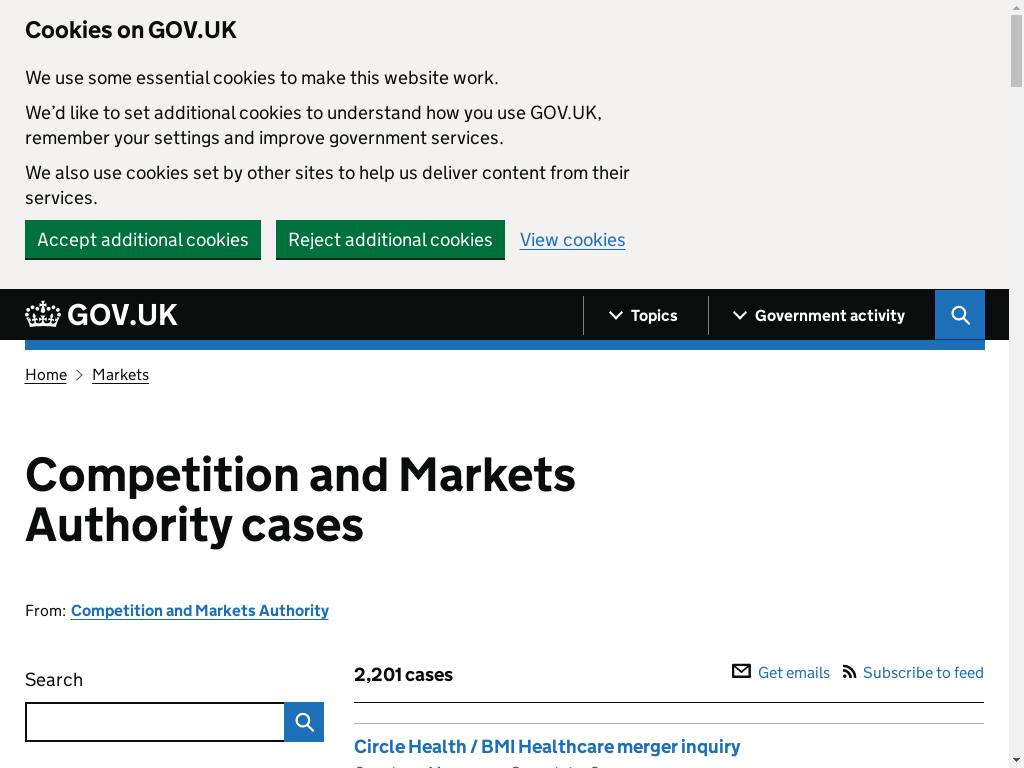

In [6]:
page.screenshot_to_notebook(driver)

First things first, we need to close the cookie banner.

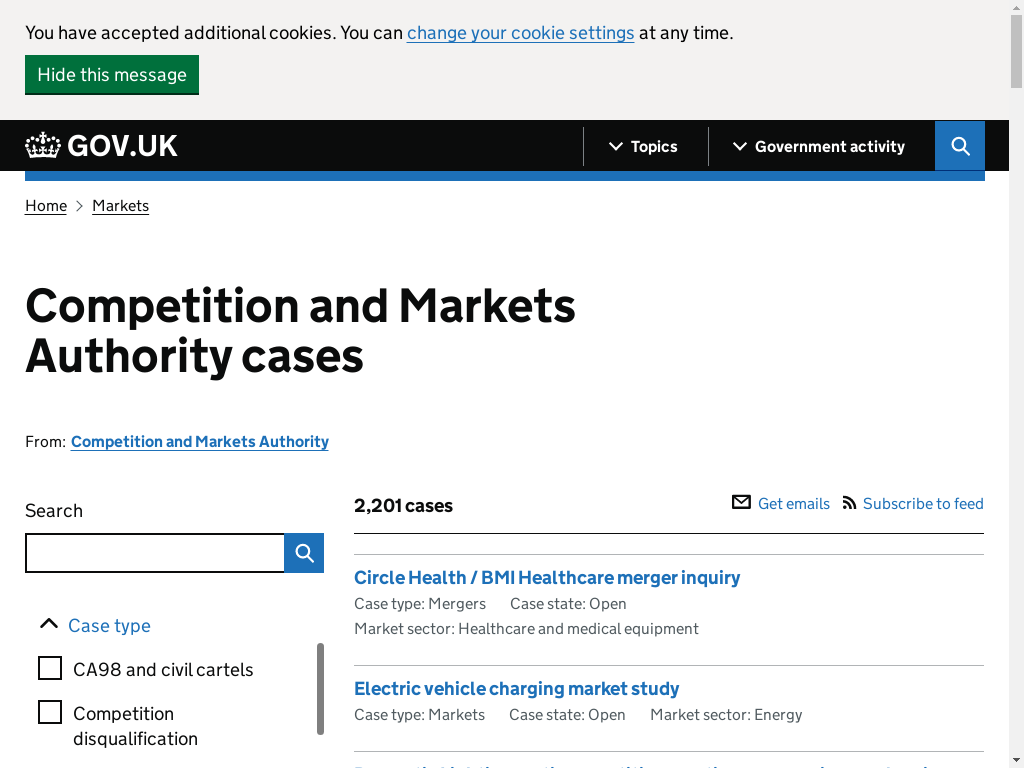

In [7]:
page.remove_cookie_banner(driver)
page.screenshot_to_notebook(driver)

Now, we grab the urls for the individual cases on the first page:

In [8]:
urls = page.get_case_links()
urls[:3]

['/cma-cases/nec-software-solutions-uk-slash-capita-secure-solutions-and-services-merger-inquiry',
 '/cma-cases/gxo-logistics-slash-clipper-logistics-merger-inquiry',
 '/cma-cases/dye-and-durham-uk-limited-slash-tm-group-uk-limited-merger-inquiry']

We visit the first 3 links (using our second PageCmaCase page object) and grab the case name and published date and store this in a pandas dataframe.

In [9]:
case_names = []
published_dates = []

for url in urls[:3]:
    full_url = f"http://www.gov.uk{url}"
    page_case = PageCmaCase.from_url(driver, full_url, logger=None)
    case_names.append(page_case.get_case_name())
    published_dates.append(page_case.get_published_date(driver))
    
results = pd.DataFrame({"case": case_names,
                        "published_date": published_dates})

In [10]:
results

,case,published_date
0,NEC Software Solutions UK / Capita Secure Solu...,5 January 2022
1,GXO Logistics / Clipper Logistics merger inquiry,18 May 2022
2,Dye & Durham (UK) Limited / TM Group (UK) Limi...,1 September 2021


### Putting it all together

Let's imagine you wanted to collect the case names / published dates for all CMA cases. The workflow might look something like this:

1. Load first case list page
2. Generate all urls for inidividual cases
3. Load these case pages in turn, collating the required information
4. Click next page
5. Repeat steps 2 to 4

You can use the selene Crawler class for executing this type of workflow, as in the example below:

In [11]:
class CrawlerCma(CrawlerSelene):
    """ a crawler object to collect data from the CMA website on cases """
    
    def collect_case_data(self, driver, logger, page_limit, start_url = "http://www.gov.uk/cma-cases"):
        """ a function to crawl CMA case lists and collect case names / published dates """
        case_names = []
        published_dates = []
        page_count = 1
        page_list = PageCmaCaseList.from_url(driver, start_url, logger = logger, string="cma-cases")
        
        while page_count <= page_limit:    
            page_urls = page_list.get_case_links()
            current_handle = driver.window_handles[0]

            for url in page_urls[:5]: # just getting the first 5 links to save some time!
                full_url = f"http://www.gov.uk{url}"
                sleep(np.random.uniform(low=1, high=5)) # out of politeness
                page_case = PageCmaCase.new_tab(driver, full_url, logger=None)
                case_names.append(page_case.get_case_name())
                published_dates.append(page_case.get_published_date(driver))
                page_case.close_all_tabs_except_specified_tab(driver, handle_keep=current_handle)
                self.log(f'Number of tabs open: {len(driver.window_handles)}')
                  
            page_list.click_next_page(driver)
            page_count += 1
        
        results = pd.DataFrame({"case": case_names,
                        "published_date": published_dates})
        return results
                    

Let's see it in action:

In [12]:
crawler = CrawlerCma()
output = crawler.collect_case_data(driver=driver, logger=logger, page_limit=2)

2022-05-18 14:22:37 INFO     Logger started
2022-05-18 14:22:37 DEBUG    navigate to: http://www.gov.uk/cma-cases
2022-05-18 14:22:37 DEBUG    task_navigate_to_url: http://www.gov.uk/cma-cases; cma-cases
2022-05-18 14:22:37 DEBUG    bool_url_unexpected: http://www.gov.uk/cma-cases
2022-05-18 14:22:38 DEBUG    bool_url_changed: https://www.gov.uk/cma-cases/dye-and-durham-uk-limited-slash-tm-group-uk-limited-merger-inquiry
2022-05-18 14:22:38 DEBUG    bool_url_contains: cma-cases
2022-05-18 14:22:38 DEBUG    WORKER-00: find_all: a; {'class': re.compile('.*gem-c-document.*govuk-link.*')}
2022-05-18 14:23:01 DEBUG    Crawler: Number of tabs open: 1
2022-05-18 14:23:25 DEBUG    Crawler: Number of tabs open: 1
2022-05-18 14:23:47 DEBUG    Crawler: Number of tabs open: 1
2022-05-18 14:24:09 DEBUG    Crawler: Number of tabs open: 1
2022-05-18 14:24:32 DEBUG    Crawler: Number of tabs open: 1
2022-05-18 14:24:32 DEBUG    task_find: //*[@id="js-pagination"]/nav/ul/li/a
2022-05-18 14:24:32 DEBUG 

In [13]:
output

,case,published_date
0,NEC Software Solutions UK / Capita Secure Solu...,5 January 2022
1,GXO Logistics / Clipper Logistics merger inquiry,18 May 2022
2,Dye & Durham (UK) Limited / TM Group (UK) Limi...,1 September 2021
3,London Stock Exchange Group PLC / Quantile Gro...,3 March 2022
4,Investigation into Google’s ‘Privacy Sandbox’ ...,8 January 2021
5,NEC Software Solutions UK / Capita Secure Solu...,5 January 2022
6,GXO Logistics / Clipper Logistics merger inquiry,18 May 2022
7,Dye & Durham (UK) Limited / TM Group (UK) Limi...,1 September 2021
8,London Stock Exchange Group PLC / Quantile Gro...,3 March 2022
9,Investigation into Google’s ‘Privacy Sandbox’ ...,8 January 2021


This code could be written outside of selene, but sometimes it's helpful to retain useful code within the selene framework so it can be re-used in future.

In [14]:
stop_driver(driver)